In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -U -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hariharanfut","key":"f2bbe3e49912bce8e0bc547455cf3ef4"}'}

In [5]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d nancychen0129/caltech101
!unzip /content/caltech101.zip

Streaming output truncated to the last 5000 lines.
  inflating: Caltech101/train/Motorbikes/image_0607.jpg  
  inflating: Caltech101/train/Motorbikes/image_0609.jpg  
  inflating: Caltech101/train/Motorbikes/image_0612.jpg  
  inflating: Caltech101/train/Motorbikes/image_0614.jpg  
  inflating: Caltech101/train/Motorbikes/image_0615.jpg  
  inflating: Caltech101/train/Motorbikes/image_0616.jpg  
  inflating: Caltech101/train/Motorbikes/image_0617.jpg  
  inflating: Caltech101/train/Motorbikes/image_0618.jpg  
  inflating: Caltech101/train/Motorbikes/image_0619.jpg  
  inflating: Caltech101/train/Motorbikes/image_0620.jpg  
  inflating: Caltech101/train/Motorbikes/image_0621.jpg  
  inflating: Caltech101/train/Motorbikes/image_0622.jpg  
  inflating: Caltech101/train/Motorbikes/image_0623.jpg  
  inflating: Caltech101/train/Motorbikes/image_0624.jpg  
  inflating: Caltech101/train/Motorbikes/image_0625.jpg  
  inflating: Caltech101/train/Motorbikes/image_0626.jpg  
  inflating: Caltech1

In [7]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import imageio
import skimage.transform
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfdb
import keras
from keras import callbacks
from keras import optimizers
from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [8]:
def imread(path):
    img = imageio.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
    
path = '/content/Caltech101/train'
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
train = []
train_labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    iter = 0
    for f in os.listdir(path + "/" + category):
        if iter == 0:
            ext = os.path.splitext(f)[1]
            if ext.lower() not in valid_exts:
                continue
            fullpath = os.path.join(path + "/" + category, f)
            img = skimage.transform.resize(imageio.imread(fullpath), [128,128, 3])
            img = img.astype('float32')
            img[:,:,0] -= 123.68
            img[:,:,1] -= 116.78
            img[:,:,2] -= 103.94
            train.append(img) # NORMALIZE IMAGE 
            label_curr = i
            train_labels.append(label_curr)
        #iter = (iter+1)%10;
print ("Num imgs: %d" % (len(train)))
print ("Num labels: %d" % (len(train_labels)) )
print (ncategories)

[101] CATEGORIES ARE IN 
 /content/Caltech101/train
Num imgs: 6162
Num labels: 6162
101


In [9]:
def imread(path):
    img = imageio.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
    
path = '/content/Caltech101/test'
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
test = []
test_labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    iter = 0
    for f in os.listdir(path + "/" + category):
        if iter == 0:
            ext = os.path.splitext(f)[1]
            if ext.lower() not in valid_exts:
                continue
            fullpath = os.path.join(path + "/" + category, f)
            img = skimage.transform.resize(imageio.imread(fullpath), [128,128, 3])
            img = img.astype('float32')
            img[:,:,0] -= 123.68
            img[:,:,1] -= 116.78
            img[:,:,2] -= 103.94
            test.append(img) # NORMALIZE IMAGE 
            label_curr = i
            test_labels.append(label_curr)
        #iter = (iter+1)%10;
print ("Num imgs: %d" % (len(test)))
print ("Num labels: %d" % (len(test_labels)) )
print (ncategories)

[101] CATEGORIES ARE IN 
 /content/Caltech101/test
Num imgs: 1695
Num labels: 1695
101


In [10]:
def imread(path):
    img = imageio.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
    
path = '/content/Caltech101/eval'
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
vald = []
vald_labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    iter = 0
    for f in os.listdir(path + "/" + category):
        if iter == 0:
            ext = os.path.splitext(f)[1]
            if ext.lower() not in valid_exts:
                continue
            fullpath = os.path.join(path + "/" + category, f)
            img = skimage.transform.resize(imageio.imread(fullpath), [128,128, 3])
            img = img.astype('float32')
            img[:,:,0] -= 123.68
            img[:,:,1] -= 116.78
            img[:,:,2] -= 103.94
            vald.append(img) # NORMALIZE IMAGE 
            label_curr = i
            vald_labels.append(label_curr)
        #iter = (iter+1)%10;
print ("Num imgs: %d" % (len(vald)))
print ("Num labels: %d" % (len(vald_labels)) )
print (ncategories)

[101] CATEGORIES ARE IN 
 /content/Caltech101/eval
Num imgs: 820
Num labels: 820
101


In [11]:
X_train= np.array(train)
X_train= X_train/255.0

X_test= np.array(test)
X_test= X_test/255.0

X_vald= np.array(vald)
X_vald= X_vald/255.0

In [13]:
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)
X_vald = np.stack(X_vald, axis=0)

In [14]:
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical( train_labels, num_classes = 102)
y_testHot = to_categorical( test_labels, num_classes = 102)
y_valdHot = to_categorical( vald_labels, num_classes = 102)

In [15]:
base_model = keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128, 3))

87916544/87910968 [==============================] - 7s 0us/step


In [16]:
last = base_model.get_layer('mixed10').output
# Add classification layers on top of it
x = BatchNormalization()
x = BatchNormalization()


x = Flatten()(last)
x= Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(1042, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(102, activation='softmax')(x)

model =Model(base_model.input, pred)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [18]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [19]:
a = X_train
b = y_trainHot

In [20]:
history = model.fit(a, b, epochs=300, batch_size=128, validation_data=(X_vald,y_valdHot))

Train on 6162 samples, validate on 820 samples
Epoch 1/300
6162/6162 [==============================] - 38s 6ms/step - loss: 0.0643 - accuracy: 0.9900 - val_loss: 0.0553 - val_accuracy: 0.9902
Epoch 2/300
6162/6162 [==============================] - 15s 2ms/step - loss: 0.0625 - accuracy: 0.9900 - val_loss: 0.0553 - val_accuracy: 0.9902
Epoch 3/300
6162/6162 [==============================] - 15s 2ms/step - loss: 0.0612 - accuracy: 0.9901 - val_loss: 0.0558 - val_accuracy: 0.9902
Epoch 4/300
6162/6162 [==============================] - 15s 2ms/step - loss: 0.0593 - accuracy: 0.9901 - val_loss: 0.0562 - val_accuracy: 0.9902
Epoch 5/300
6162/6162 [==============================] - 15s 2ms/step - loss: 0.0585 - accuracy: 0.9902 - val_loss: 0.0555 - val_accuracy: 0.9902
Epoch 6/300
6162/6162 [==============================] - 15s 2ms/step - loss: 0.0577 - accuracy: 0.9902 - val_loss: 0.0552 - val_accuracy: 0.9902
Epoch 7/300
6162/6162 [==============================] - 15s 2ms/step - loss:

In [21]:
test_loss, test_acc = model.evaluate(X_test,y_testHot)
print("Test Loss: ", test_loss*100)
print("Test Accuracy: ", test_acc*100)

1695/1695 [==============================] - 3s 2ms/step
Test Loss:  4.026813287298939
Test Accuracy:  99.27700757980347


VGG -Validation Loss:  3.9649184575168097
VGG - Validation Accuracy:  99.28980469703674


VGG - Training Loss:  4.154964644039888
VGG - Training Accuracy:  99.23582077026367




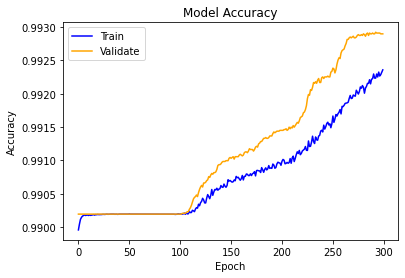

In [25]:
plt.plot(history.history['accuracy'], 'blue')
plt.plot(history.history['val_accuracy'], 'orange')
plt.title("Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.savefig("/content/drive/My Drive/results/VGG 19/caltech101/Model Accuracy.png")

print("VGG -Validation Loss: ", history.history['val_loss'][-1]*100)
print("VGG - Validation Accuracy: ", history.history['val_accuracy'][-1]*100)
print("\n")
print("VGG - Training Loss: ", history.history['loss'][-1]*100)
print("VGG - Training Accuracy: ", history.history['accuracy'][-1]*100)
print("\n")

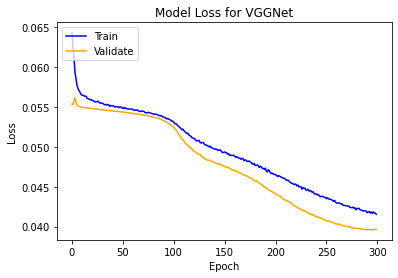

In [26]:
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'orange')
plt.title("Model Loss for VGGNet")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.savefig("/content/drive/My Drive/results/VGG 19/caltech101/Model loss.png")

In [23]:
from tensorflow.keras import Model
import h5py
from keras.models import load_model
model.save('/content/drive/My Drive/results/INCEPTION_V3/caltech101/caltech101-inceptionv3.h5')

In [27]:
output = model.predict(X_test)
output = np.argmax(np.round(output),axis=1)

In [28]:
print(np.unique(output))
set(test_labels) - set(output)

[0 1 3 5]


{2,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100}

In [29]:
target_names = []
for i in range(101):
    a = 'Object '
    b = str(i)
    c = a+b
    c = [i]
    target_names.append((a+b))

def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    kc=cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    #mse=mean_squared_error(y_test, y_pred)
    #mae=mean_absolute_error(y_test, y_pred)
    #precision=precision_score(y_test, y_pred, average='weighted')
    #print(classification_report(y_test, y_pred, target_names=target_names))


    
    return classification, confusion, Test_Loss, Test_accuracy ,kc#,mse,mae

In [30]:
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score
# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy,kc = reports(X_test,y_testHot)
classification = str(classification)
confusion_str = str(confusion)

  96/1695 [>.............................] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1695/1695 [==============================] - 2s 1ms/step


In [31]:
print("confusion matrix: ")
print('{}'.format(confusion_str))
print("KAppa Coeefecient=",kc)
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
#print("Mean Squared error=",mse)
#print("Mean absolute error=",mae)
print(classification)

confusion matrix: 
[[83  3  0 ...  0  0  0]
 [ 1 83  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
KAppa Coeefecient= 0.2123431226387601
Test loss 4.026813287298939 (%)
Test accuracy 99.27700757980347 (%)
              precision    recall  f1-score   support

    Object 0       0.99      0.95      0.97        87
    Object 1       0.93      0.95      0.94        87
    Object 2       0.00      0.00      0.00        40
    Object 3       0.92      0.97      0.94       159
    Object 4       0.00      0.00      0.00        11
    Object 5       0.12      1.00      0.21       160
    Object 6       0.00      0.00      0.00         8
    Object 7       0.00      0.00      0.00         8
    Object 8       0.00      0.00      0.00         9
    Object 9       0.00      0.00      0.00        10
   Object 10       0.00      0.00      0.00         9
   Object 11       0.00      0.00      0.00         6
   Object 12    

Confusion matrix, without normalization


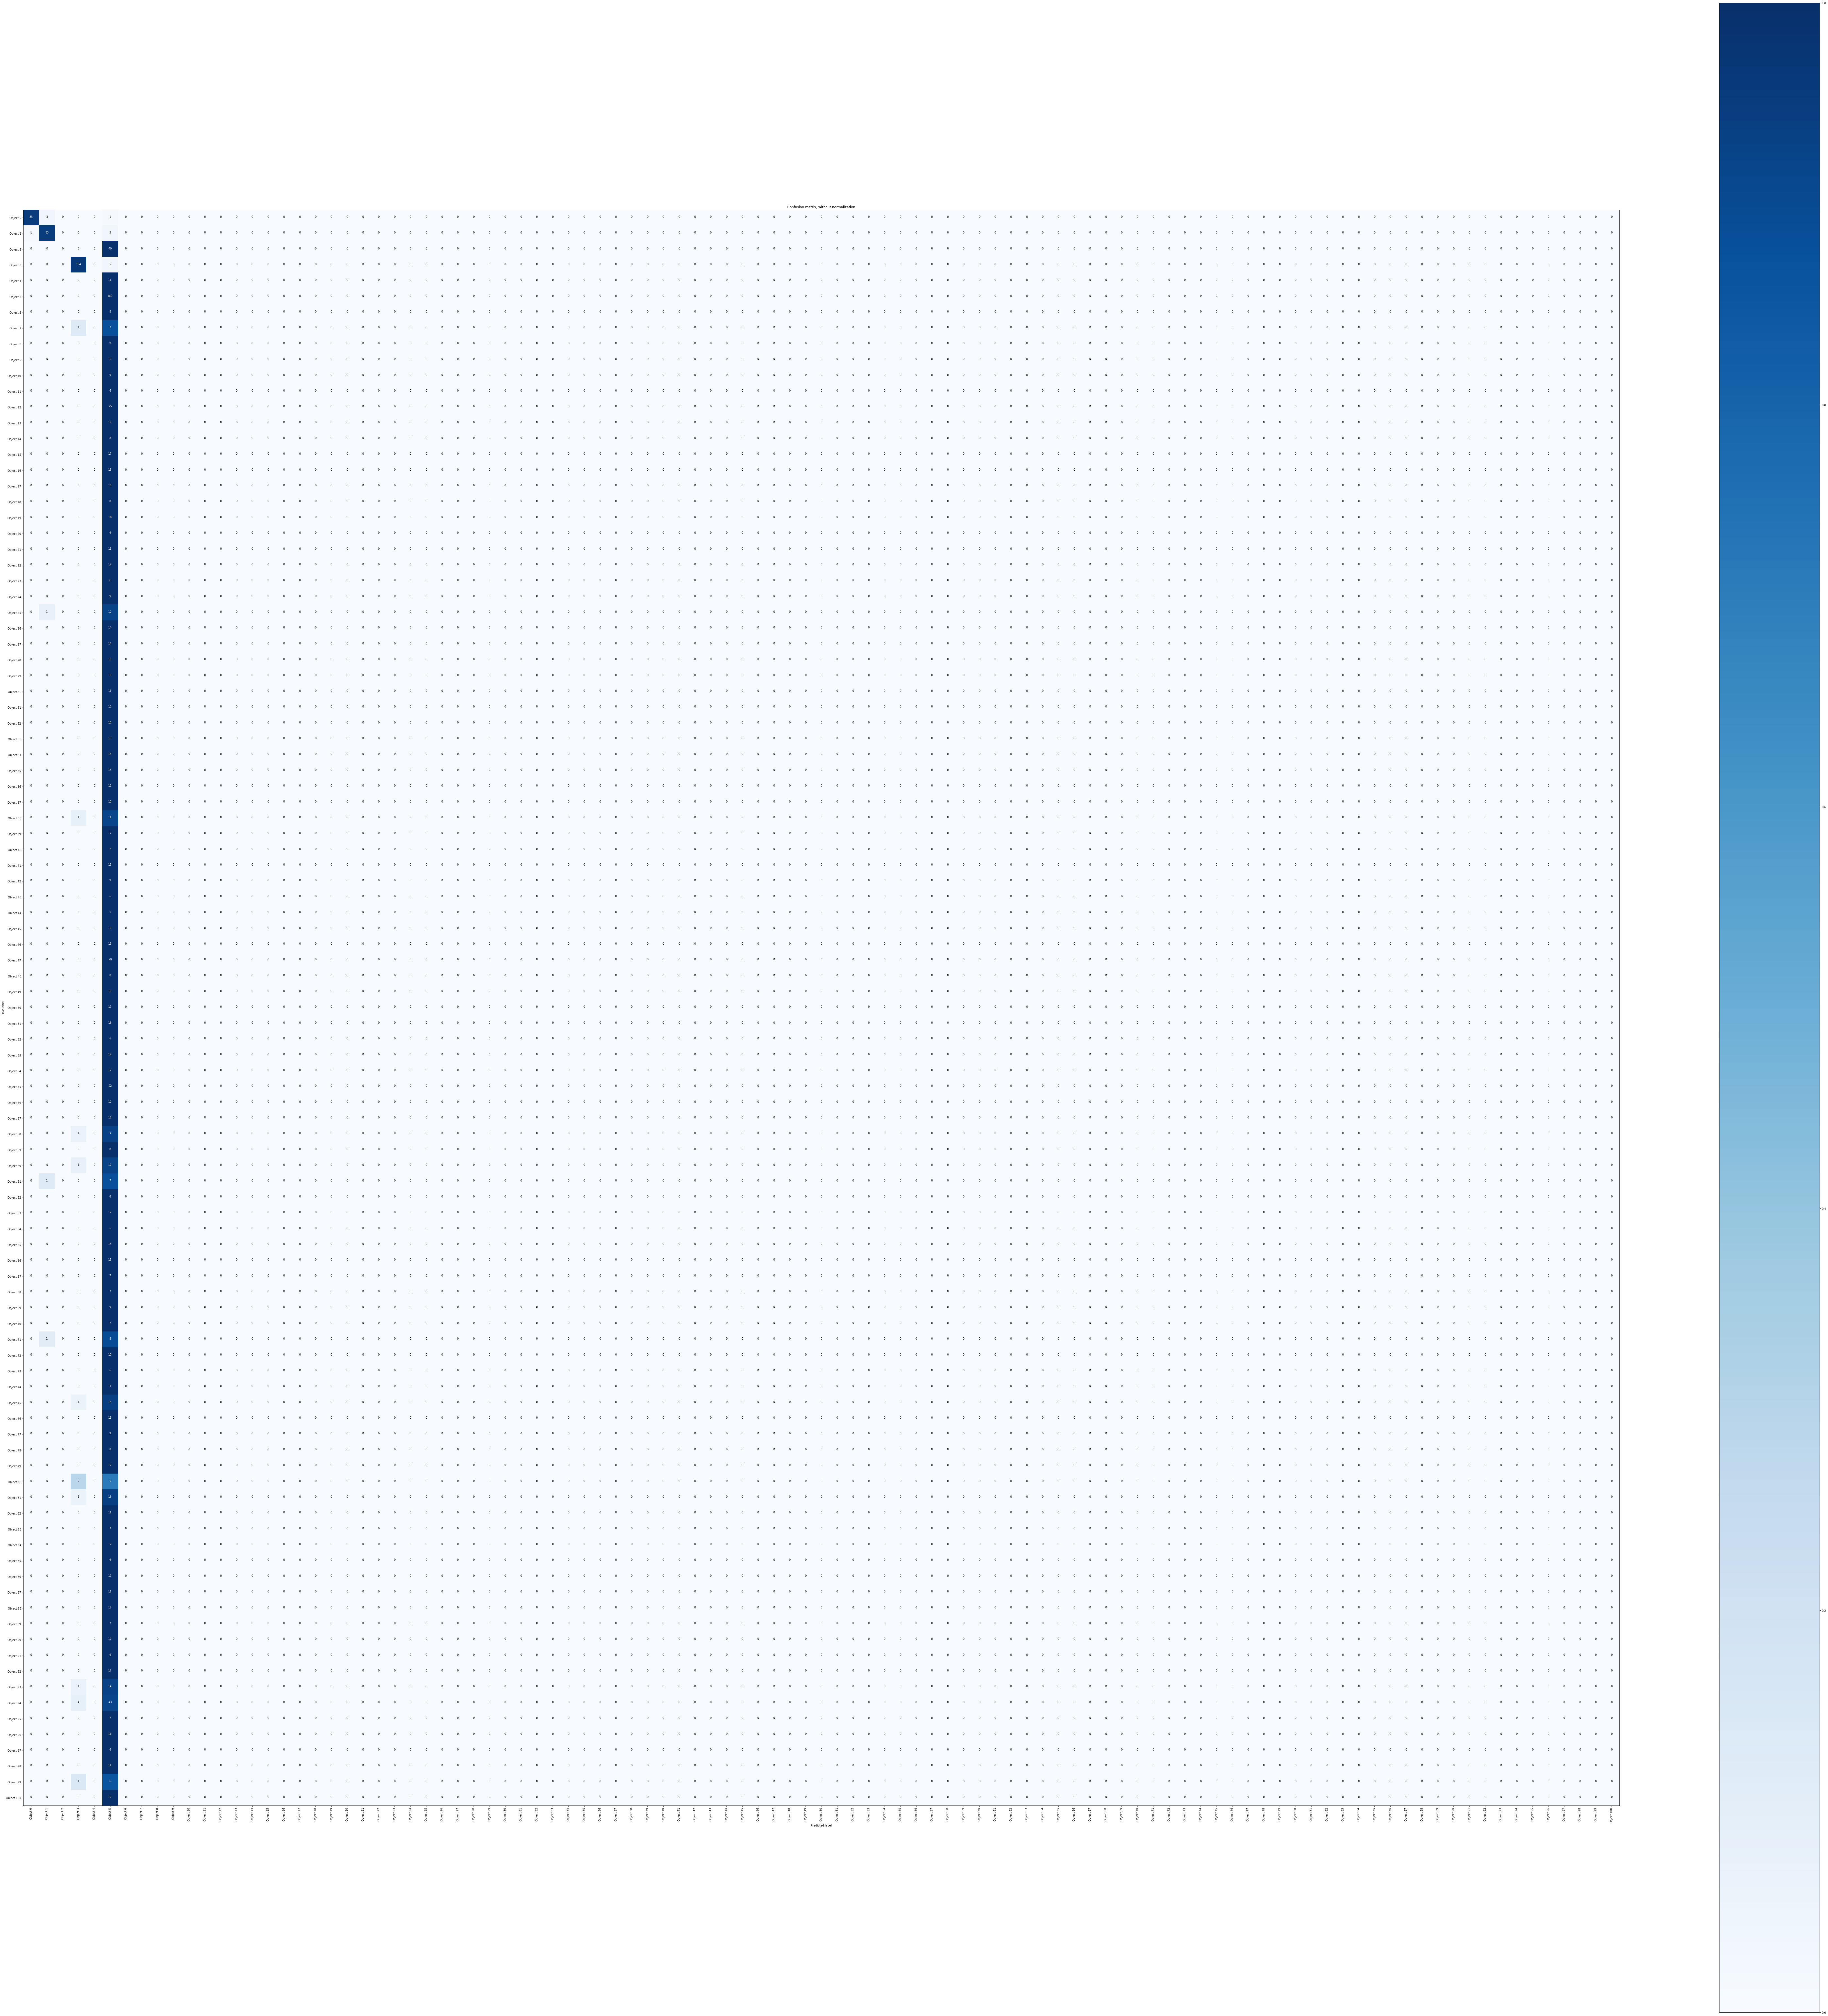

Normalized confusion matrix


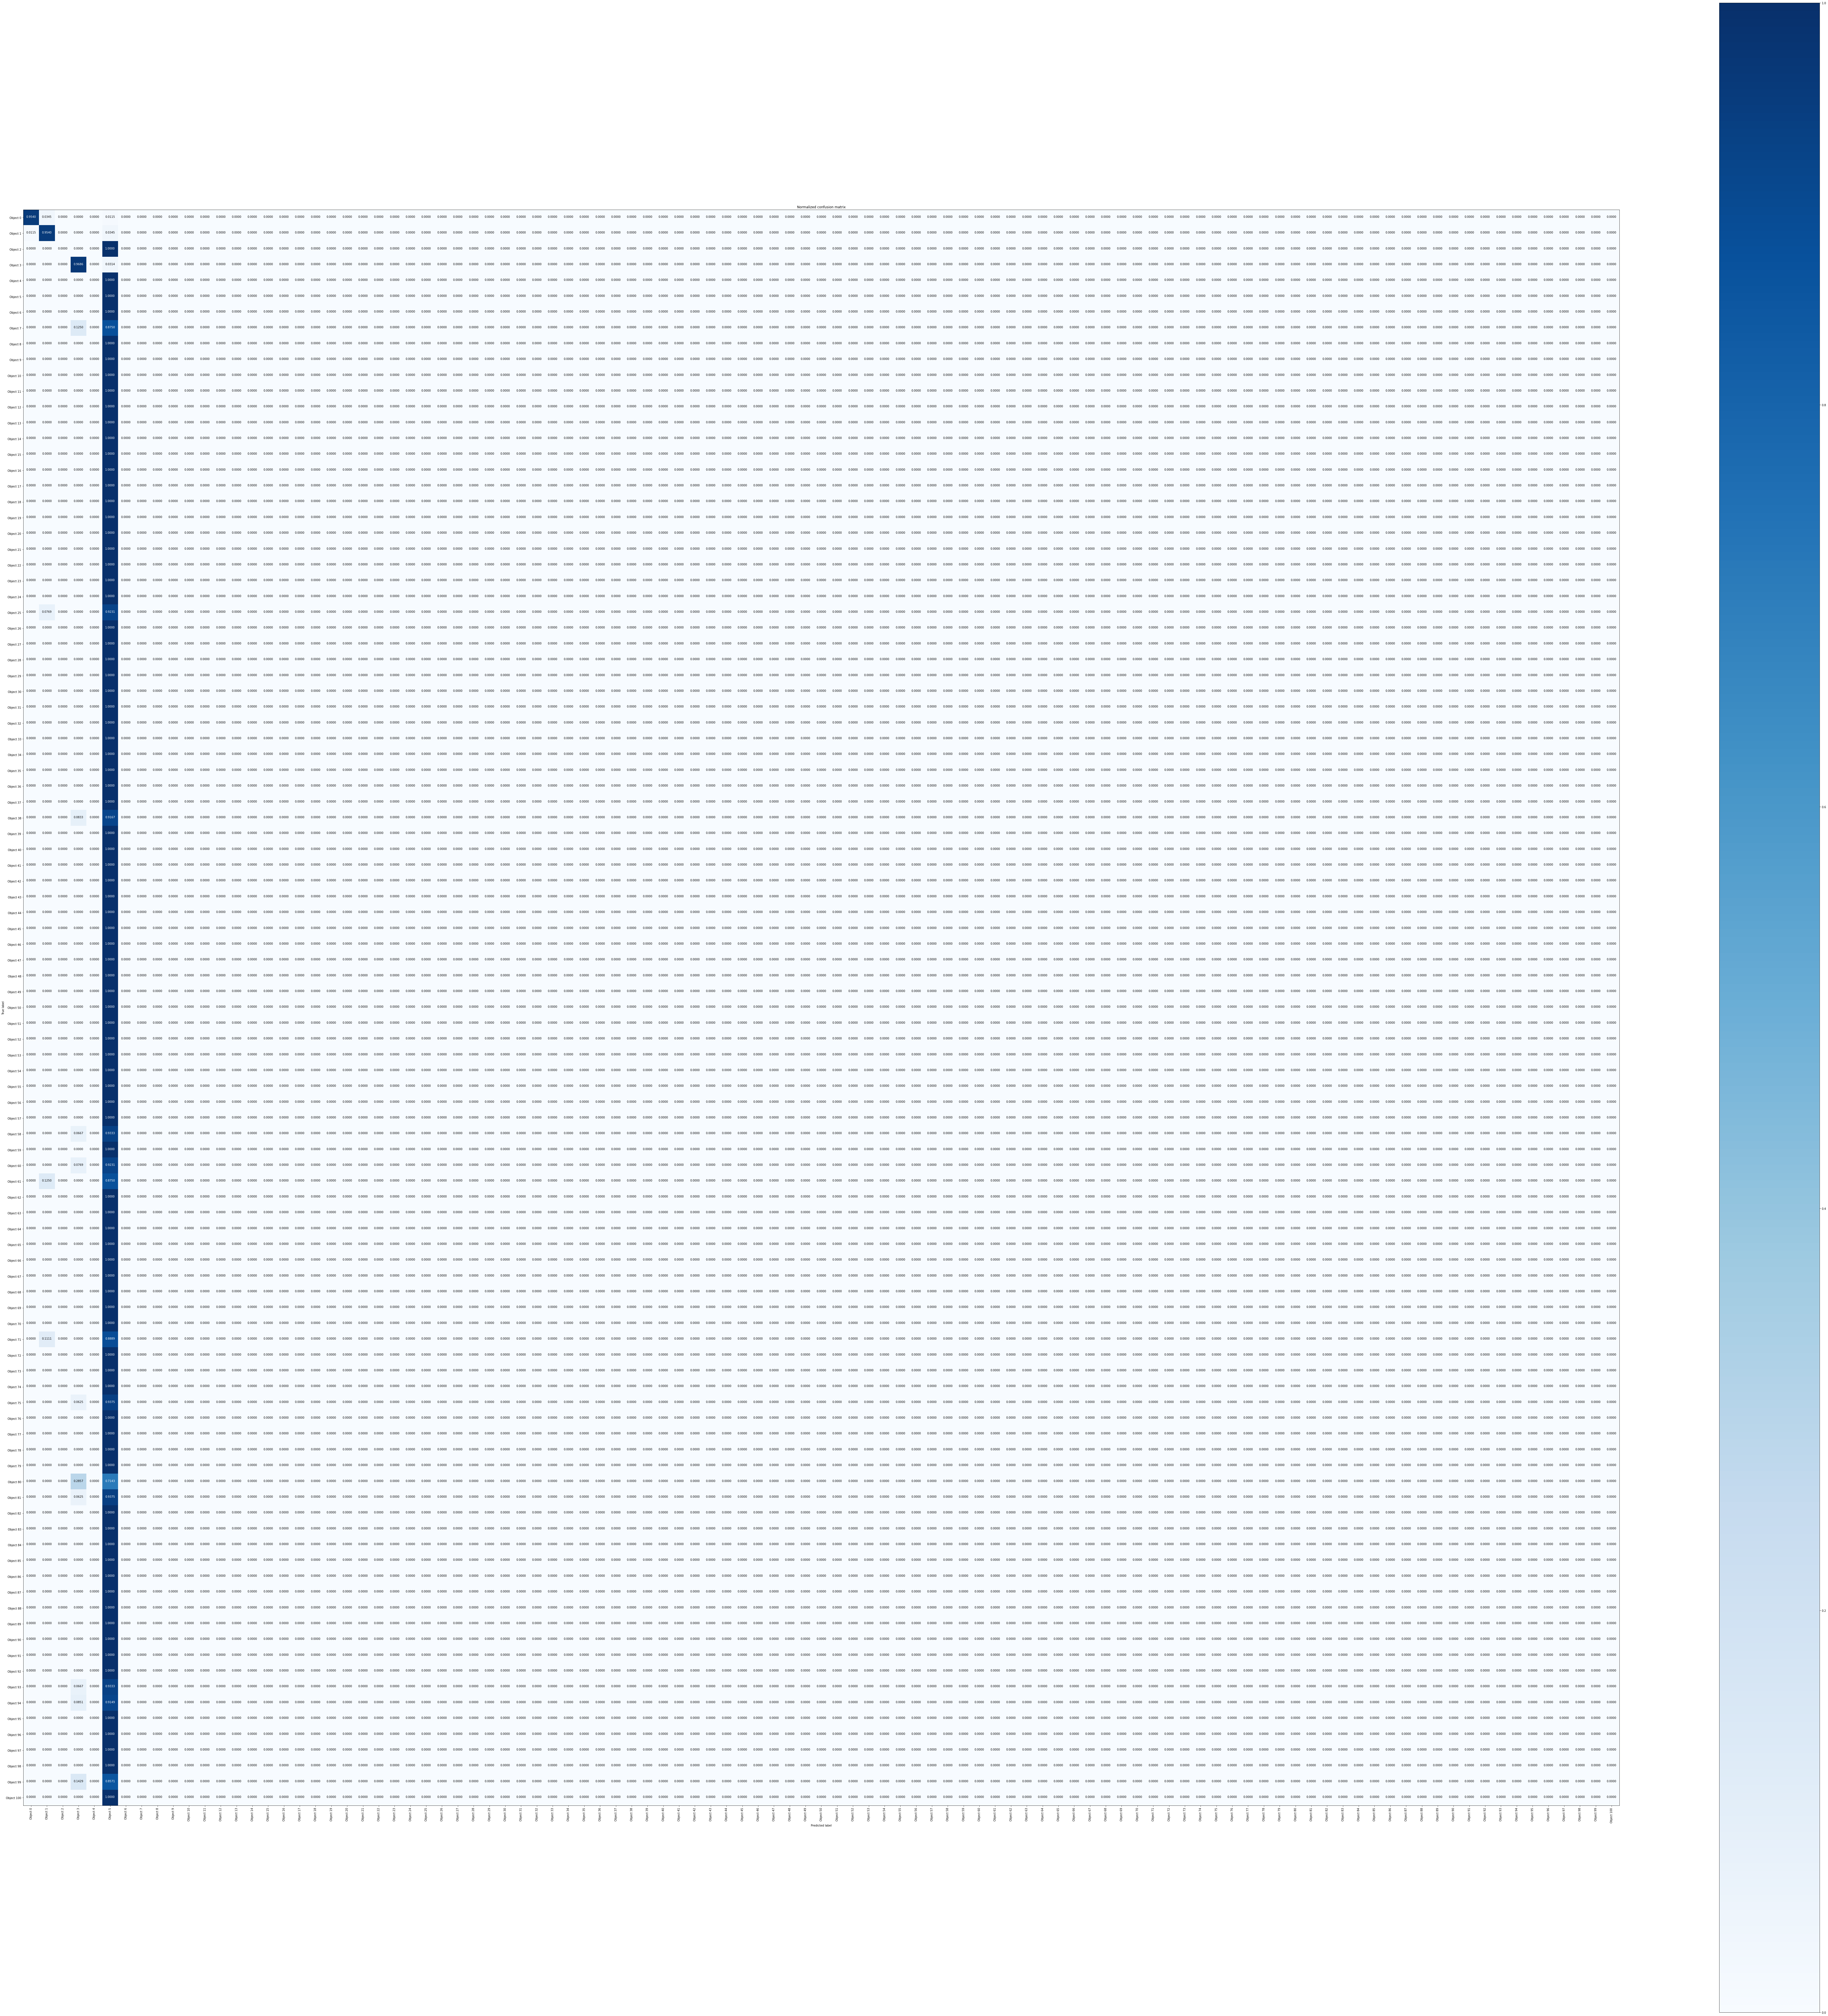

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if normalize:
        cm = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = cm[i].max() / 2.
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(100,100))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, 
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/My Drive/results/INCEPTION_V3/caltech101/confusion_matrix_without_normalization.png")
plt.show()
plt.figure(figsize=(100,100))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, 
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/My Drive/results/INCEPTION_V3/caltech101/confusion_matrix_with_normalization.png")
plt.show()